In [1]:
import pandas as pd
import numpy as np
from settings import Config
from mysql_db import Database
import pdcast as pdc
import s3_upload_download as s3con
import os
from datetime import datetime

# NOTEBOOK DESCRIPTION: 

Exploration and cleaning of the predictors needed for the frequency and severity analyses for PERSONAL CARS (autoturisme). Following the KPMG report, these are:

1. Driver's age (varsta), binned into categories
2. Car's cylinder capacity (capacitate), binned into categories


In [2]:
# initialise the s3_connector object needed to read/write files into an S3 bucket
s3con = s3con.s3_connector()

In [3]:
# load tables
category = s3con.read('att6_category_type.feather')
capacity = s3con.read('att8_capacity.feather')
age = s3con.read('att2_age.feather')
type = s3con.read('att1_type.feather')

## STEP I - Combine analysis elements into one dataframe
This involves:
1. Selecting all policies of personal cars
2. Adding the age and power columns


In [4]:
cat = (
    category
    .query("categorie == 'Autoturism'") # select only the policies belonging to personal cars
    .filter(items = ['idPolita']) # only need the policy id column
    .merge(capacity, on = 'idPolita', how = 'left') # merge with capacity, age and type (legal/individual persons)
    .merge(age, on = 'idPolita', how = 'left')
    .merge(type, on = 'idPolita', how = 'left')
)

del category, capacity, age, type
cat.shape[0]

21731441

## STEP II - EDA and Cleaning
Start by performing a quick EDA on the dataframe to spot any obvious issues.

In [5]:
# check for total duplicates and for policy id duplicates
print('Total duplicates: ', cat.duplicated().sum())
print('Policy ID duplicates: ', cat.duplicated('idPolita').sum())

Total duplicates:  0
Policy ID duplicates:  0


In [6]:
# check for nans
cat.isnull().sum()

idPolita      0
capacitate    0
varsta        0
tip           0
dtype: int64

In [7]:
# check column types
cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21731441 entries, 0 to 21731440
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   idPolita    uint32  
 1   capacitate  uint16  
 2   varsta      int16   
 3   tip         category
dtypes: category(1), int16(1), uint16(1), uint32(1)
memory usage: 352.3 MB


In [8]:
# descriptive stats
cat.describe().T

,count,mean,std,min,25%,50%,75%,max
idPolita,21731441.0,3.027331e+07,5.252161e+07,2230446.0,8705560.0,15438072.0,22876617.0,203964267.0
capacitate,21731441.0,1.751406e+03,4.534270e+02,0.0,1461.0,1686.0,1968.0,19000.0
varsta,21731441.0,7.265910e+01,8.074015e+01,-29.0,37.0,48.0,63.0,321.0


Issues:
1. Capacity has a minimum of zero, which is not possible;
2. Age has negative values.

In [9]:
# before analysing and cleaning each attribute, 
# separate (for size management) the legal persons (PJ) from the individual persons (PF)
# then delete column Type

pj = (
    cat
    .query("tip == 'PJ'")
    .filter(items = ['idPolita', 'capacitate', 'varsta'])
)

pf = (
    cat
    .query("tip == 'PF'")
    .filter(items = ['idPolita', 'capacitate', 'varsta'])
)

del cat

In [10]:
print('Number of individual persons: ', pf.shape[0])
print('Number of legal persons: ', pj.shape[0])

Number of individual persons:  19707765
Number of legal persons:  2023676


### Cylinder Capacity 

For personal cars, a cylinder capacity in the 500 - 7500 range is considered 'normal'.

In [11]:
# select policies with capacity outside the above range
outliers_pf = (
    pf.query("capacitate < 500 or capacitate > 7500")
)

outliers_pj = (
    pj.query("capacitate < 500 or capacitate > 7500")
)


Before attempting to clean, I will investigate whether these are worth the trouble by calculating:
1. The percentage of outliers
2. The percentage of events from all personal car events (events = accidents)
3. The percentage of claim value from the total claim valu of personal cars

In [12]:
# percentage of outliers
print(f"PF outliers in all policies: {outliers_pf.shape[0]/pf.shape[0]:.2%}")
print(f"PJ outliers in all policies: {outliers_pj.shape[0]/pj.shape[0]:.2%}")

PF outliers in all policies: 0.01%
PJ outliers in all policies: 0.16%


In [13]:
# percentage of events
ev = s3con.read('events_no.feather')

print(f'Percentage for PF: {ev[ev.idPolita.isin(outliers_pf.idPolita.values)].total_ev.sum()/ev[ev.idPolita.isin(pf.idPolita.values)].total_ev.sum():.2%}')

print(f'Percentage for PJ: {ev[ev.idPolita.isin(outliers_pj.idPolita.values)].total_ev.sum()/ev[ev.idPolita.isin(pj.idPolita.values)].total_ev.sum():.2%}')

del ev

Percentage for PF: 0.01%
Percentage for PJ: 0.19%


In [14]:
# percentage of claim value
val = s3con.read('claims_vals.feather')

print(f'Percentage for PF: {val[val.idPolita.isin(outliers_pf.idPolita.values)].total_val.sum()/val[val.idPolita.isin(pf.idPolita.values)].total_val.sum():.2%}')

print(f'Percentage for PJ: {val[val.idPolita.isin(outliers_pj.idPolita.values)].total_val.sum()/val[val.idPolita.isin(pj.idPolita.values)].total_val.sum():.2%}')
                                
del val

Percentage for PF: 0.01%
Percentage for PJ: 0.20%


CONCLUSION: the outlier policies do not contain significant numbers of events, nor did they cost a sig. value. Therefore, they will be DROPPED.

In [15]:
pf.drop(pf[pf.idPolita.isin(outliers_pf.idPolita.values)].index, axis = 0, inplace = True)
pf.reset_index(drop = True, inplace = True)

pj.drop(pj[pj.idPolita.isin(outliers_pj.idPolita.values)].index, axis = 0, inplace = True)
pj.reset_index(drop = True, inplace = True)

### Age

Age only matters for individual persons (persoane fizice), therefore the age column from legal persons df can be dropped.

In [18]:
pj.drop('varsta', axis = 1, inplace = True)
pj.head(5)

,idPolita,capacitate
0,2232129,1896
1,2232423,1598
2,2232475,1598
3,2232484,1598
4,2233867,2953


In [19]:
# this df is done, so it can now be saved to S3
pj.to_feather('autoturisme_pj.feather')
s3con.write('autoturisme_pj.feather')
os.remove('autoturisme_pj.feather')

The age range considered normal is 18 to 100 (whilst there is no official upper age restriction, it is very unlike that there are drivers over 100).

In [16]:
pf.query("varsta < 18 or varsta > 100")

,idPolita,capacitate,varsta
12303,2243138,1289,101
31117,2262349,1997,321
58383,2290398,3498,321
99579,2333089,1149,102
131127,2366402,2986,321
...,...,...,...
19634810,203867225,1390,17
19642229,203877266,1968,16
19667987,203913351,3222,104
19671028,203917513,1968,17


There appear to values of '321'. These were added by me to the original df containing both legal and individual persons, as a means to represent the legal persons, who are not supposed to have any age value, so that there won't be any nans.

Their existence in the individual persons df suggests that there were some true nans before, and as such '321' will be treated as a nan.

These will be replace with the mean or median (depending on the distribution) of the 'normal' slice (18-100) of the df. 

<AxesSubplot:ylabel='Frequency'>

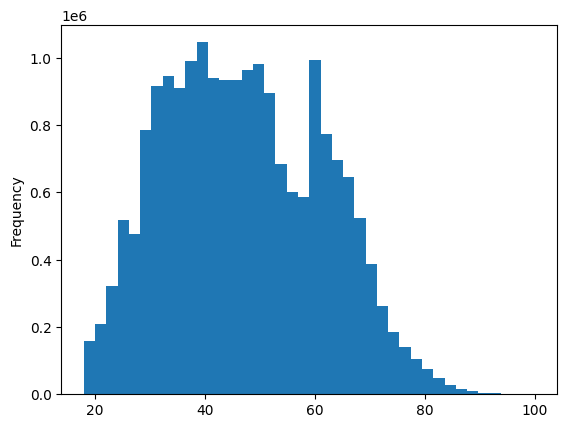

In [19]:
pf.query("varsta >= 18 and varsta <= 100").varsta.plot(kind = 'hist', bins = 40)

The distribution is not completely normal. The median should be a better measure.

In [27]:
print(f'Mean: {np.mean(pf.query("varsta >= 18 and varsta <= 100").varsta)}')
print(f'Median: {np.median(pf.query("varsta >= 18 and varsta <= 100").varsta)}')

Mean: 47.155578284557954
Median: 46.0


In [28]:
pf.varsta.replace({321:46}, inplace = True)

In [33]:
# how many under 18
pf.query("varsta < 18").varsta.describe()

count    1410.000000
mean       15.725532
std         2.870617
min       -29.000000
25%        16.000000
50%        17.000000
75%        17.000000
max        17.000000
Name: varsta, dtype: float64

In [36]:
# first I will convert all negative values to positives by muliplying with -1
pf.varsta = [x*(-1) if x < 0 else x for x in pf.varsta.values]

In [38]:
# since most of the under 18 are 16 and 17, which are likey to be errors meant to have been 18, 
# I will replace 16 and 17 with 18

pf.varsta.replace({16:18, 17:18}, inplace = True)

The age of the remaining < 18 will be replaced with the median age of the group of drivers associated with the average cylinder capacity of the group < 18. 

In [45]:
# find the average cylinder capacity of this group
pf.query("varsta < 18").capacitate.describe()

count     290.000000
mean     1912.800000
std       571.664026
min       898.000000
25%      1595.000000
50%      1910.000000
75%      1983.000000
max      5654.000000
Name: capacitate, dtype: float64

In [46]:
# then find the median age of this group
np.median(pf.query("capacitate == 1910").varsta)

43.0

In [48]:
# finally, replace the under 18 age values with the above value
pf.varsta = [43 if x < 18 else x for x in pf.varsta.values]
pf.query("varsta < 18")


,idPolita,capacitate,varsta


Check for those above 100.

In [50]:
pf.query("varsta > 100").varsta.describe()

count     51.000000
mean     104.313725
std        5.140001
min      101.000000
25%      101.000000
50%      102.000000
75%      104.000000
max      118.000000
Name: varsta, dtype: float64

Given the low numbers, the fact that most are under 104, and that the max value is 118, these do not require modification.

In [51]:
# final look at the stats of this dataframe
pf.describe().T

,count,mean,std,min,25%,50%,75%,max
idPolita,19705603.0,2.980679e+07,5.232001e+07,2230446.0,8336059.5,14896736.0,22710541.5,203964267.0
capacitate,19705603.0,1.747487e+03,4.312382e+02,500.0,1461.0,1716.0,1968.0,7500.0
varsta,19705603.0,4.715398e+01,1.427385e+01,18.0,36.0,46.0,58.0,118.0


In [52]:
# save the table to S3
pf.to_feather('autoturisme_pf.feather')
s3con.write('autoturisme_pf.feather')
os.remove('autoturisme_pf.feather')